In [23]:
# 📦 Block 1 – Read and clean the CSV file

import pandas as pd

# Path to your file on Colab
file_path = "/content/Misura flusso vs angolo_CRC_OCRA_PCTO2025.CSV"

# Read the CSV with the correct separator and encoding
df = pd.read_csv(file_path, sep=';', encoding='latin1')

# Convert numeric columns (comma → dot, then to float)
numeric_cols = ["Angel [°]", "Flux [Hz]", "ERR. [Hz]"]
for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Keep only valid numeric rows
df = df.dropna(subset=numeric_cols).sort_values(by="Angel [°]")

print(f"✅ CSV loaded successfully with {len(df)} valid rows.")
display(df.head())


✅ CSV loaded successfully with 10 valid rows.


Angel [°]  Alt. [m] Temp. [°C]  GATE [min] Avarenge ST.DEV st.dev-err  \
0          0        21       23,6           2       98   0,82        0,2   
1         10        21       23,6           2     85,5   1,67       0,41   
2         20        21       23,6           2       80   0,68        0,2   
3         30        21       23,6           2     70,5   1,18        0,3   
4         40        21       23,6           2     53,5   1,19       0,41   

   Flux [Hz]  ERR. [Hz]  
0      0.817      0.034  
1      0.713      0.068  
2      0.667      0.033  
3      0.588      0.050  
4      0.446      0.103

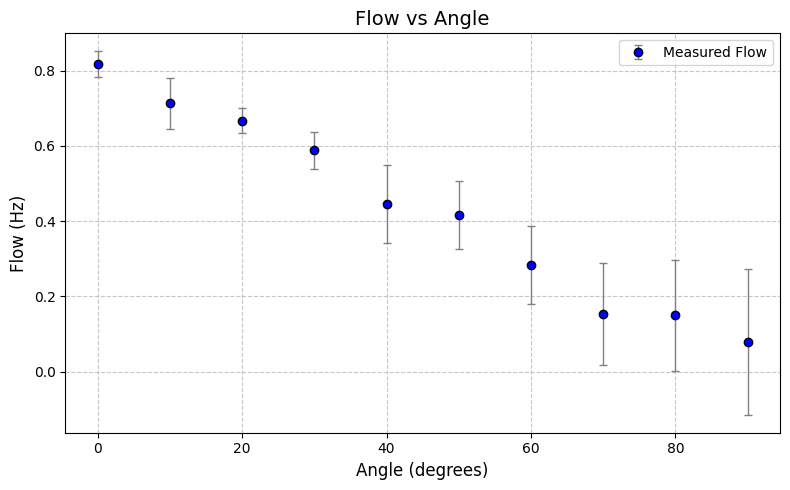

In [24]:
# 📊 Block 2 – Plot Flow vs Angle with error bars (points only)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Plot only the points with error bars (no connecting line)
plt.errorbar(
    df["Angel [°]"],
    df["Flux [Hz]"],
    yerr=df["ERR. [Hz]"],
    fmt='o',               # only points, no line
    ecolor='gray',
    elinewidth=1,
    capsize=3,
    capthick=1,
    markersize=6,
    markerfacecolor='blue',
    markeredgecolor='black',
    label="Measured Flow"
)

# English labels and styling
plt.title("Flow vs Angle", fontsize=14)
plt.xlabel("Angle (degrees)", fontsize=12)
plt.ylabel("Flow (Hz)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


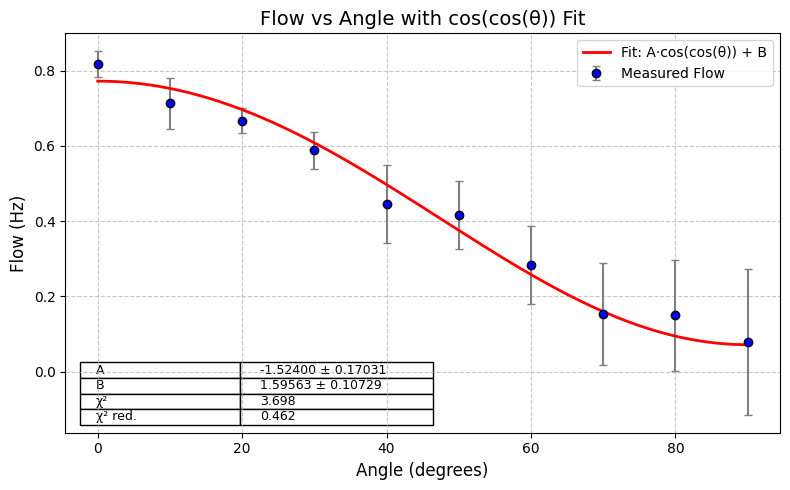

In [25]:
# 🧮 Block 3 – Fit with A*cos(cos(theta)) + B and compact table at bottom-left

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Define the model: f(θ) = A * cos(cos(θ)) + B
def model(theta_rad, A, B):
    return A * np.cos(np.cos(theta_rad)) + B

# Convert angle from degrees to radians
theta_rad = np.deg2rad(df["Angel [°]"])
y = df["Flux [Hz]"]
y_err = df["ERR. [Hz]"]

# Perform the curve fit with weights = 1/σ²
popt, pcov = curve_fit(model, theta_rad, y, sigma=y_err, absolute_sigma=True)
A_fit, B_fit = popt
A_err, B_err = np.sqrt(np.diag(pcov))

# Compute chi-squared and reduced chi-squared
y_fit = model(theta_rad, *popt)
chi2 = np.sum(((y - y_fit) / y_err) ** 2)
ndof = len(y) - len(popt)
chi2_red = chi2 / ndof

# --- Plot ---
plt.figure(figsize=(8,5))

# Experimental points with error bars
plt.errorbar(
    df["Angel [°]"], y, yerr=y_err,
    fmt='o', ecolor='gray', capsize=3, markersize=6,
    markerfacecolor='blue', markeredgecolor='black', label="Measured Flow"
)

# Fitted curve
theta_fit_deg = np.linspace(df["Angel [°]"].min(), df["Angel [°]"].max(), 300)
theta_fit_rad = np.deg2rad(theta_fit_deg)
plt.plot(theta_fit_deg, model(theta_fit_rad, *popt), 'r-', lw=2, label='Fit: A·cos(cos(θ)) + B')

# Labels and style
plt.title("Flow vs Angle with cos(cos(θ)) Fit", fontsize=14)
plt.xlabel("Angle (degrees)", fontsize=12)
plt.ylabel("Flow (Hz)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# --- Add compact summary table (bottom-left corner) ---
table_data = [
    ["A", f"{A_fit:.5f} ± {A_err:.5f}"],
    ["B", f"{B_fit:.5f} ± {B_err:.5f}"],
    ["χ²", f"{chi2:.3f}"],
    ["χ² red.", f"{chi2_red:.3f}"]
]

table = plt.table(
    cellText=table_data,
    colLabels=None,
    cellLoc="left",
    loc="lower left",
    colWidths=[0.25, 0.3]
)

# Make it smaller and tidy
table.scale(0.9, 0.9)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.set_alpha(0.8)  # slight transparency

# Adjust layout
plt.tight_layout()
plt.show()
